In [2]:
import sys
import os
import Bio
from Bio import SeqIO
from Bio import Seq
import re
import pandas as pd
import time
import numpy as np
import weightedstats as ws
import csv
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.special import gammaln

In [3]:
### LIKELIHOOD MODEL ###

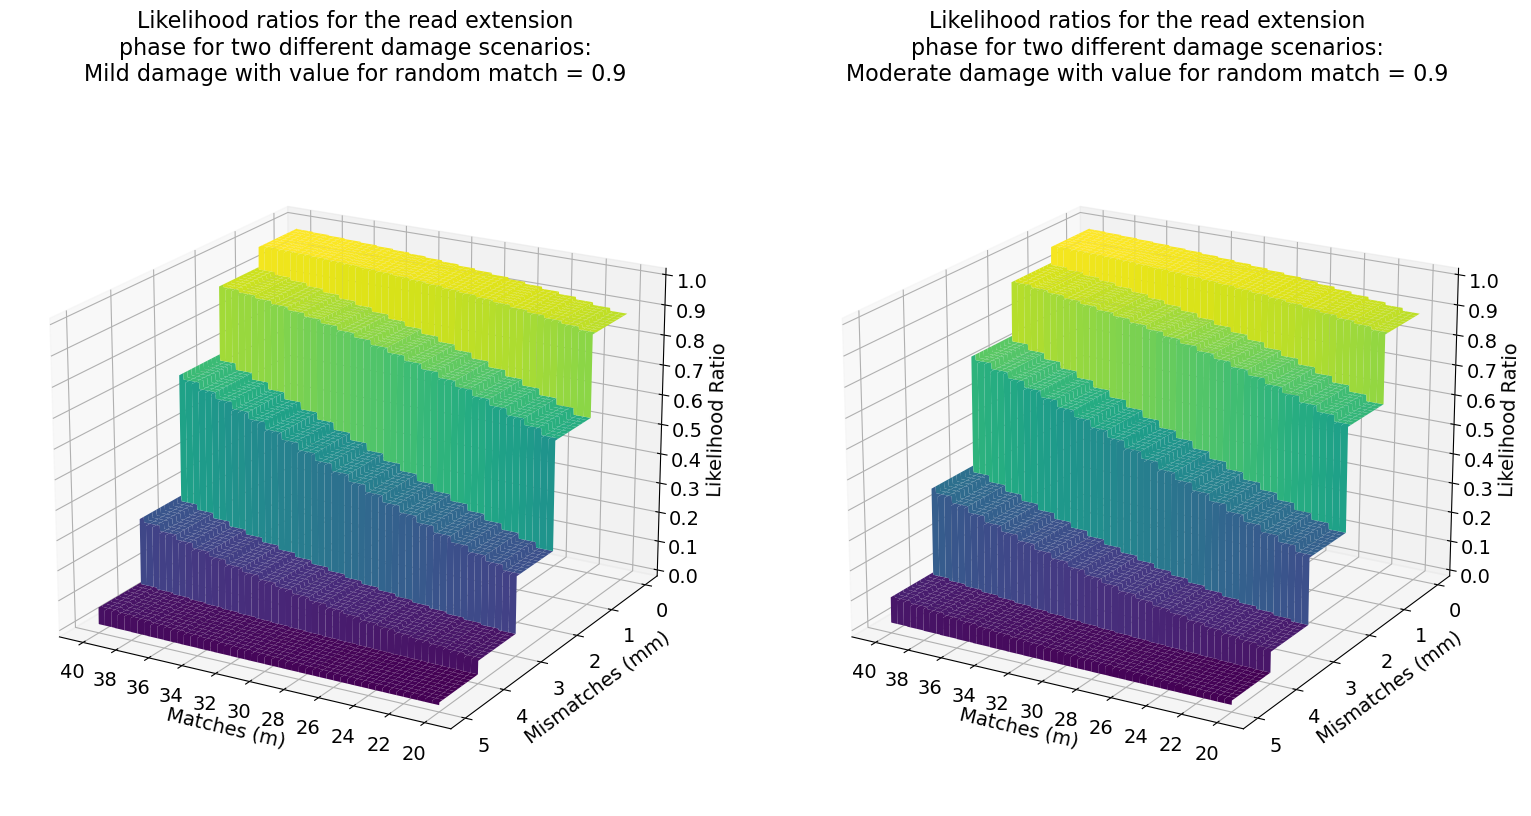

In [9]:
# Binning function to adjust values to their respective discrete ranges
def bin_values(value, bin_size=1):
    return np.floor(value / bin_size) * bin_size

# Adapted likelihood function to take steps_rates as an argument
def func(m, mm, random_match, steps_rates):
    steps_contribution = 0
    for i in range(min(int(mm), 10)):
        steps_contribution += (math.log(steps_rates[i][0]) * 1 + math.log(steps_rates[i][1]) * 1)
    remaining_m = max(0, m - 10)
    remaining_mm = max(0, mm - 10)
    b_m_rate, b_mm_rate = 0.99, 0.01  # Assuming these are constant for all steps beyond the 10th
    base_contribution = remaining_m * math.log(b_m_rate) + remaining_mm * math.log(b_mm_rate)
    total_contribution = steps_contribution + base_contribution
    exponent_part = ((mm + m) * math.log(random_match)) - total_contribution
    result = 1.0 / (1.0 + math.exp(exponent_part))
    return result

# Define random_match values and steps_rates scenarios to visualize
#random_match_values = [0.85, 0.9, 0.95]
random_match_values = [0.9]

steps_rates_scenarios = [
    #[(0.95, 0.05), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01), (0.95, 0.05), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01)],
    [(0.75, 0.25), (0.75, 0.25), (0.8, 0.2), (0.8, 0.2), (0.85, 0.15), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01)],
    [(0.65, 0.35), (0.7, 0.3), (0.75, 0.25), (0.8, 0.2), (0.85, 0.15), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01), (0.99, 0.01)]
]

# Generate mesh for m and mm
m_values = np.linspace(20, 40, 1000)  # Matches from 20 to 50
mm_values = np.linspace(0, 5, 1000)  # Mismatches from 0 to 10
M, MM = np.meshgrid(m_values, mm_values)

# Apply binning to M and MM before calculating Z
m_binned = bin_values(m_values)
mm_binned = bin_values(mm_values)

# 3D plot setup for multipanel
fig = plt.figure(figsize=(16, 8))

for row, steps_rates in enumerate(steps_rates_scenarios, start=1):
    for i, random_match in enumerate(random_match_values, start=1):
        Z = np.zeros(M.shape)
        for j in range(len(m_binned)):
            for k in range(len(mm_binned)):
                Z[k, j] =  func(m_binned[j], mm_binned[k], random_match, steps_rates)
        
        damage = ["Mild damage", "Moderate damage"]
        #ax = fig.add_subplot(2, 3, (row-1)*3 + i, projection='3d')
        ax = fig.add_subplot(1, 2, row, projection='3d')
        surf = ax.plot_surface(M, MM, Z, cmap='viridis', edgecolor='none')
        
        ax.set_xlabel('Matches (m)', fontsize=14)
        ax.set_ylabel('Mismatches (mm)', fontsize=14)
        ax.set_zlabel('Likelihood Ratio', fontsize=14)
        ax.set_title(f'Likelihood ratios for the read extension\nphase for two different damage scenarios:\n{damage[row-1]} with value for random match = {random_match}\n', fontsize=16)

        ax.set_xticks(np.arange(min(m_binned), max(m_binned)+1, 2))
        ax.set_yticks(np.arange(min(mm_binned), max(mm_binned)+1, 1))
        ax.set_zticks(np.arange(0, 1.1, 0.1))
        ax.view_init(elev=20, azim=120)
        # Change the fontsize of tick labels
        ax.tick_params(axis='x', labelsize=14) # Change 10 to your desired fontsize
        ax.tick_params(axis='y', labelsize=14) # Change 10 to your desired fontsize
        ax.tick_params(axis='z', labelsize=14) # Change 10 to your desired fontsize

# Adjust layout
plt.tight_layout()
plt.savefig(f'plotExt/likelihoodRatioReads.svg', format="svg", bbox_inches="tight")


# Show plot
plt.show()